## Build Environment

In [70]:
import os
import cv2
import keras
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.utils import resample
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import BatchNormalization,MaxPooling2D,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, precision_score, recall_score
from keras.layers import Conv2D,Dense,Dropout,GlobalAveragePooling2D,MaxPool2D

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import logging
# Set TensorFlow log level to only display errors
tf.get_logger().setLevel(logging.ERROR)

## Load Data

### Generate dataframe

In [30]:
import glob
import pandas as pd

data_dir = './dataset/Chest X-Ray/chest_xray'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'
val_dir = data_dir + '/val'

def load_data(data_dir):
    normal = glob.glob(data_dir+'/NORMAL/*.jpeg')
    pneumonia = glob.glob(data_dir+'/PNEUMONIA/*.jpeg')
    data = []
    for img in normal:
        data.append((img,0))
    for img in pneumonia:
        data.append((img,1))
    data = pd.DataFrame(data, columns=['path','label'],index=None)
    data = data.sample(frac=1).reset_index(drop=True) # shuffle the data
    return data

train_data = load_data(train_dir)
test_data = load_data(test_dir)
val_data = load_data(val_dir)

train_data.head()

,path,label
0,./dataset/Chest X-Ray/chest_xray/train/PNEUMON...,1
1,./dataset/Chest X-Ray/chest_xray/train/PNEUMON...,1
2,./dataset/Chest X-Ray/chest_xray/train/NORMAL\...,0
3,./dataset/Chest X-Ray/chest_xray/train/NORMAL\...,0
4,./dataset/Chest X-Ray/chest_xray/train/PNEUMON...,1


In [76]:
print(train_data.shape)

(3747, 2)


### Evaluate Dataset

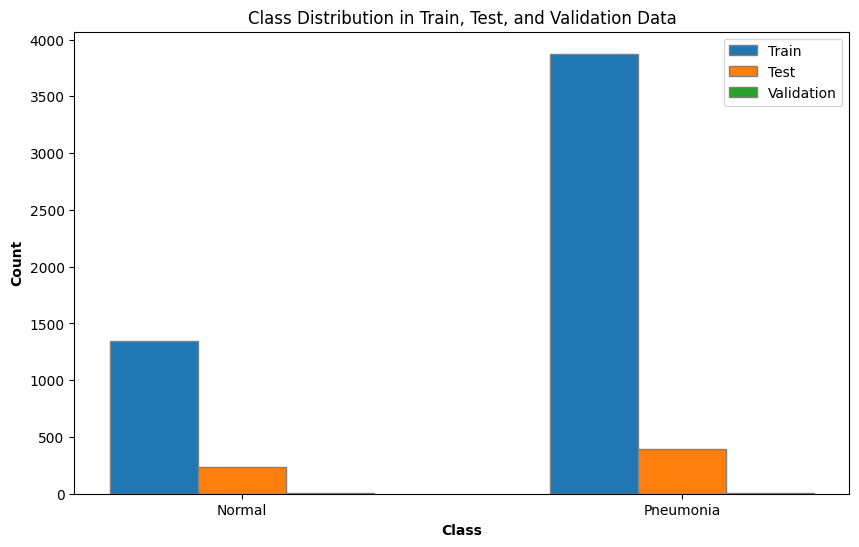

Train ---------------------------
	Normal:  1341
	Pneumonia:  3875
Test ---------------------------
	Normal:  234
	Pneumonia:  390
Validation ---------------------------
	Normal:  8
	Pneumonia:  8


In [31]:
# visualize
import matplotlib.pyplot as plt

def visualize_dataset(train_data, test_data, val_data):
    train_counts=train_data['label'].value_counts()
    test_counts=test_data['label'].value_counts()
    val_counts=val_data['label'].value_counts()

    categories = ['Normal', 'Pneumonia']
    train_values = [train_counts.get(0, 0), train_counts.get(1, 0)]
    test_values = [test_counts.get(0, 0), test_counts.get(1, 0)]
    val_values = [val_counts.get(0, 0), val_counts.get(1, 0)]

    bar_width = 0.2
    r1 = range(len(categories))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width*2 for x in r1]

    plt.figure(figsize=(10, 6))

    plt.bar(r1, train_values, color='#1f77b4', width=bar_width, edgecolor='grey', label='Train')
    plt.bar(r2, test_values, color='#ff7f0e', width=bar_width, edgecolor='grey', label='Test')
    plt.bar(r3, val_values, color='#2ca02c', width=bar_width, edgecolor='grey', label='Validation')

    plt.xlabel('Class', fontweight='bold')
    plt.ylabel('Count', fontweight='bold')
    plt.xticks([r + bar_width for r in range(len(categories))], categories)
    plt.title('Class Distribution in Train, Test, and Validation Data')
    plt.legend()

    plt.show()


    print("Train ---------------------------")
    print("\tNormal: ",train_counts[0])
    print("\tPneumonia: ",train_counts[1])
    print("Test ---------------------------")
    print("\tNormal: ",test_counts[0])
    print("\tPneumonia: ",test_counts[1])
    print("Validation ---------------------------")
    print("\tNormal: ",val_counts[0])
    print("\tPneumonia: ",val_counts[1])
    
visualize_dataset(train_data, test_data, val_data)

#### Analysis of Dataset
* the validation set is too small: this will lead to unstable validation result, which makes it hard for us to evaluate the performance of model 
* solution: combine 3 datasets, resplit

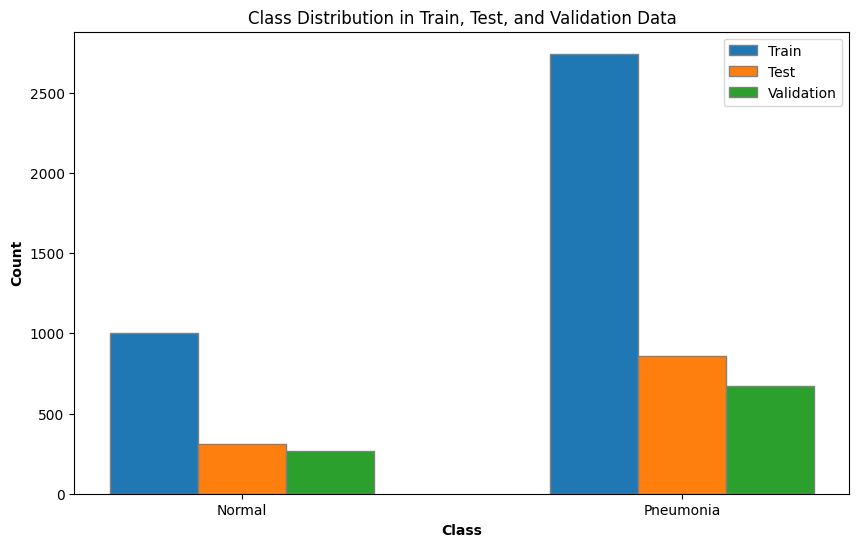

Train ---------------------------
	Normal:  1003
	Pneumonia:  2744
Test ---------------------------
	Normal:  313
	Pneumonia:  859
Validation ---------------------------
	Normal:  267
	Pneumonia:  670


In [32]:
# combine
total_set = pd.concat([train_data, test_data, val_data])
total_set = total_set.sample(frac=1).reset_index(drop=True) # shuffle the data
# split
train_data, test_data = train_test_split(total_set, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
# visualize
visualize_dataset(train_data, test_data, val_data)

### Display Dataset

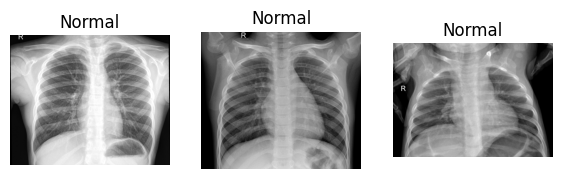

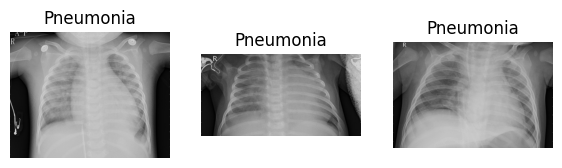

In [34]:
import matplotlib.pyplot as plt

def display_images(data, label, num_images=3):
    img_paths = data[data['label'] == label].head(num_images)['path']
    plt.figure(figsize=(7, 5))
    for i, img_path in enumerate(img_paths):
        img = plt.imread(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img, cmap='gray')
        plt.title('Normal' if label == 0 else 'Pneumonia')
        plt.axis('off')
    plt.show()
    
display_images(train_data, 0) # Normal
display_images(train_data, 1) # Pneumonia

### Preprocess image

In [38]:
## params
target_size = (300, 300)

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(    
    rescale=1.0/255,        
#     shear_range=0.2,      # aug
#     rotation_range=.1,
#     zoom_range=0.2,       
#     horizontal_flip=True ,
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='path', 
    y_col='label',   
    target_size=target_size, 
    batch_size=32,
    color_mode='rgb',
    class_mode='raw', 
    shuffle=True
)

# Validation data generator
valid_generator = test_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='path', 
    y_col='label',
    target_size=target_size, 
    batch_size=32,
    color_mode='rgb',
    class_mode='raw',
    shuffle=False  
)

# Testing data generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='path', 
    y_col='label',  
    target_size=target_size,
    batch_size=64,    
    color_mode='rgb',
    class_mode='raw',
    shuffle=False  
)

Found 3747 validated image filenames.
Found 937 validated image filenames.
Found 1172 validated image filenames.


## Construct Model

### Model structure
Constructing model based on a globally pretrained model offers numerous advantages: 
1. Reduce training time & Reduce the demand of data
2. Enhance robustness: pretrained model learned more generalizable features
3. Better performance
...  

Basic structure:

----
* MobileNetV2(pretrained, freezing):
  * pretrained on ImageNet
  * exclude top: output embedded features

----
* cnn(train):
  * extract Chest X-Ray Classification info from features
  * predict
----

In [72]:
from keras.applications import MobileNetV2
mobileNetV2 = MobileNetV2(weights='imagenet',
                          include_top=False,
                          input_shape=train_generator.image_shape)

# Freeze pretrained layers
for layer in mobileNetV2.layers:
    layer.trainable = False

In [73]:
mobileNet=keras.models.Sequential([
    mobileNetV2,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'), 
    Dropout(0.5),  
    Dense(1, activation='sigmoid') 
])

mobileNet.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

### Model Training
* monitor(measurement of performance): **val accuracy** 
* use **EarlyStopping**
* **reduce LR** when the accuracy of val has stopped improving

In [75]:
weight_path = "./result/best.weights.h5"

## Callbacks -------------------------------------------------------------------
# save model weights
checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_accuracy', 
                             verbose=1,                 # print the progress
                             save_best_only=True,
                             mode='max',
                             save_weights_only=True)
# early stopping
early = EarlyStopping(monitor="val_accuracy",
                      mode="max", 
                      patience=5)

# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.2, 
                              patience=2,
                              min_lr=1e-6,
                              mode='max')

callbacks_list = [checkpoint, early, reduce_lr]

In [ ]:
mobileNet_history=mobileNet.fit(train_generator,epochs=5,validation_data=valid_generator,callbacks=callbacks_list)

### Evaluate

In [ ]:
# load weights
mobileNet.load_weights(weight_path)

# evaluate
evaluation_result = mobileNet.evaluate(test_generator)

## display

print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])